In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import STL10
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import numpy as np

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [14]:
eval_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [15]:
train_dataset = STL10(
    root="./data",
    split="unlabeled",
    download=True,
    transform=eval_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

In [16]:
from tqdm import tqdm

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x = x.to(device)
            z = model(x)            # encoder output
            z = z.view(z.size(0), -1)
            embeddings.append(z.cpu().numpy())
            labels.append(y.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

In [ ]:
import torchvision.models as models

def get_encoder():
    resnet = models.resnet18(weights=None)
    resnet.fc = torch.nn.Identity()
    return resnet

In [17]:
simclr_encoder = get_encoder()
byol_encoder   = get_encoder()
device = "cuda"
simclr_encoder.load_state_dict(torch.load("/kaggle/input/encoder-simclr/pytorch/default/1/simclr_encoder_final_41.pth"))
byol_encoder.load_state_dict(torch.load("/kaggle/input/encoder-byol/pytorch/default/1/encoder_byol.pth"))

simclr_encoder.to(device)
byol_encoder.to(device)

for p in simclr_encoder.parameters():
    p.requires_grad = False

for p in byol_encoder.parameters():
    p.requires_grad = False

In [18]:
simclr_emb, labels = extract_embeddings(simclr_encoder, train_loader, device)
byol_emb,   _      = extract_embeddings(byol_encoder, train_loader, device)

100%|██████████| 195/195 [00:34<00:00,  5.69it/s]


In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
simclr_pca = pca.fit_transform(simclr_emb)
byol_pca   = pca.fit_transform(byol_emb)

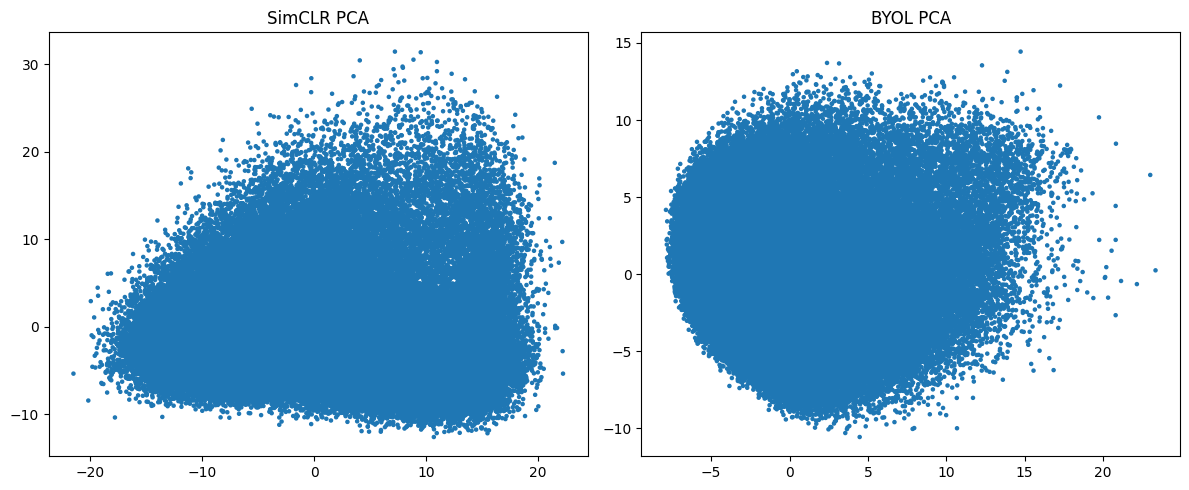

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(simclr_pca[:, 0], simclr_pca[:, 1],
                c=labels, cmap="tab10", s=5)
axes[0].set_title("SimCLR PCA")

axes[1].scatter(byol_pca[:, 0], byol_pca[:, 1],
                c=labels, cmap="tab10", s=5)
axes[1].set_title("BYOL PCA")

plt.tight_layout()
plt.show()

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42,
    init="pca"
)

simclr_tsne = tsne.fit_transform(simclr_emb)
byol_tsne   = tsne.fit_transform(byol_emb)

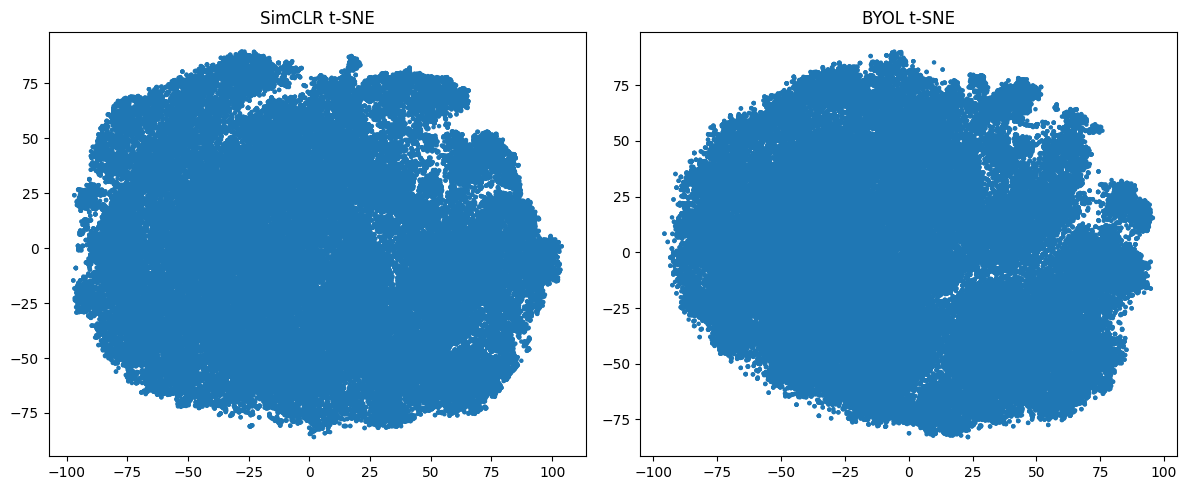

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(simclr_tsne[:, 0], simclr_tsne[:, 1],
                c=labels, cmap="tab10", s=5)
axes[0].set_title("SimCLR t-SNE")

axes[1].scatter(byol_tsne[:, 0], byol_tsne[:, 1],
                c=labels, cmap="tab10", s=5)
axes[1].set_title("BYOL t-SNE")

plt.tight_layout()
plt.show()